In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.segmentation import slic, mark_boundaries
import os
from npGraph import Graph, visuals
import torch

In [11]:
im = cv2.imread("test_images/17.1972.swine.healthy.3.10X.PNG")

In [12]:
im.shape
t = np.zeros_like(im)
t[:,:,0] = 16+(65/256)*im[:,:,2]+(129/256)*im[:,:,1]+(25/256)*im[:,:,0]
t[:,:,1] = 128-(37/256)*im[:,:,2]-(74/256)*im[:,:,1]+(112/256)*im[:,:,0]
t[:,:,2] = 16+(112/256)*im[:,:,2]-(94/256)*im[:,:,1]+(18/256)*im[:,:,0]
# im = np.stack((y, cb, cr), axis=-1).astype(int)

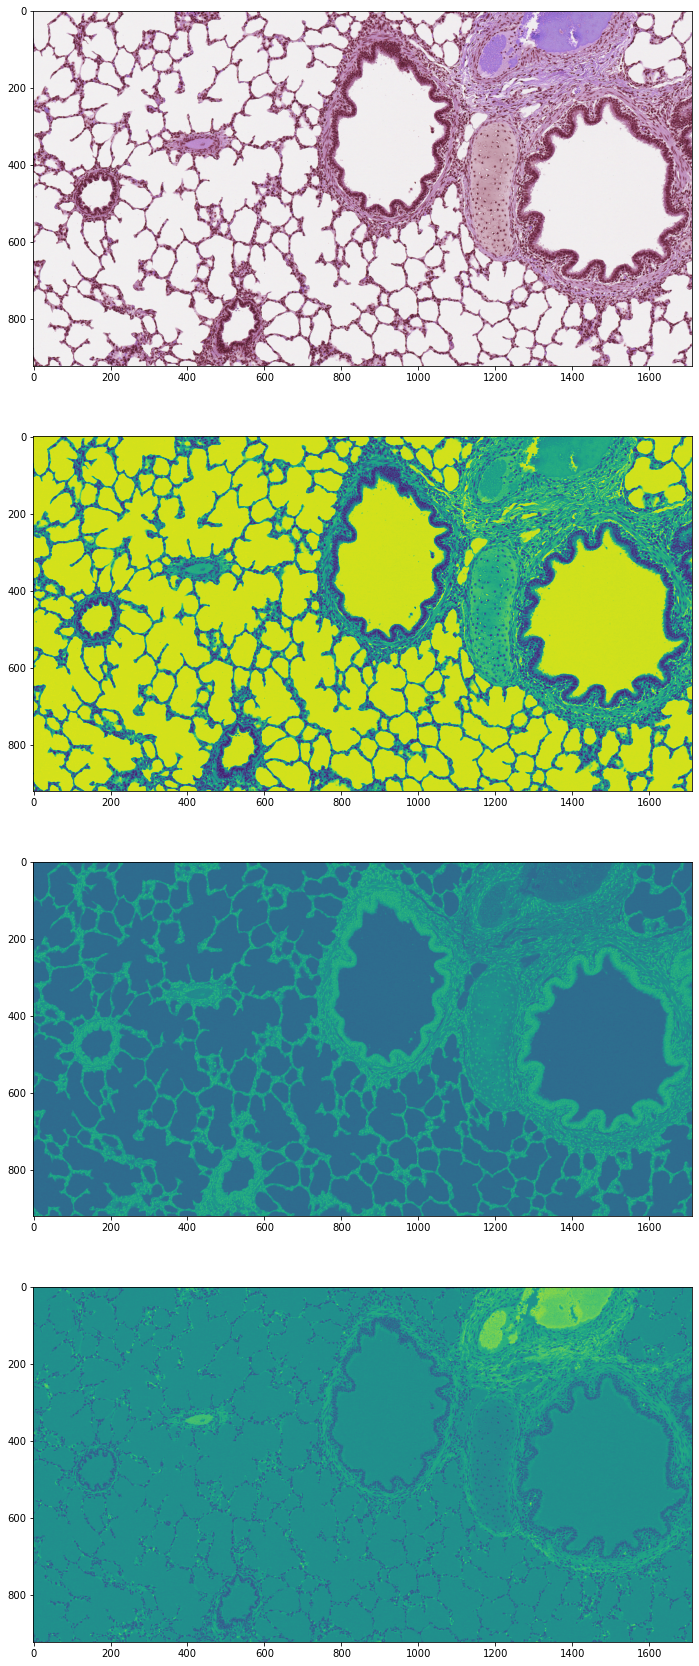

In [13]:
fig, axs = plt.subplots(4, figsize=(30,30))
axs[0].imshow(im)
for i in range(3):
    axs[i+1].imshow(t[:, :, i])

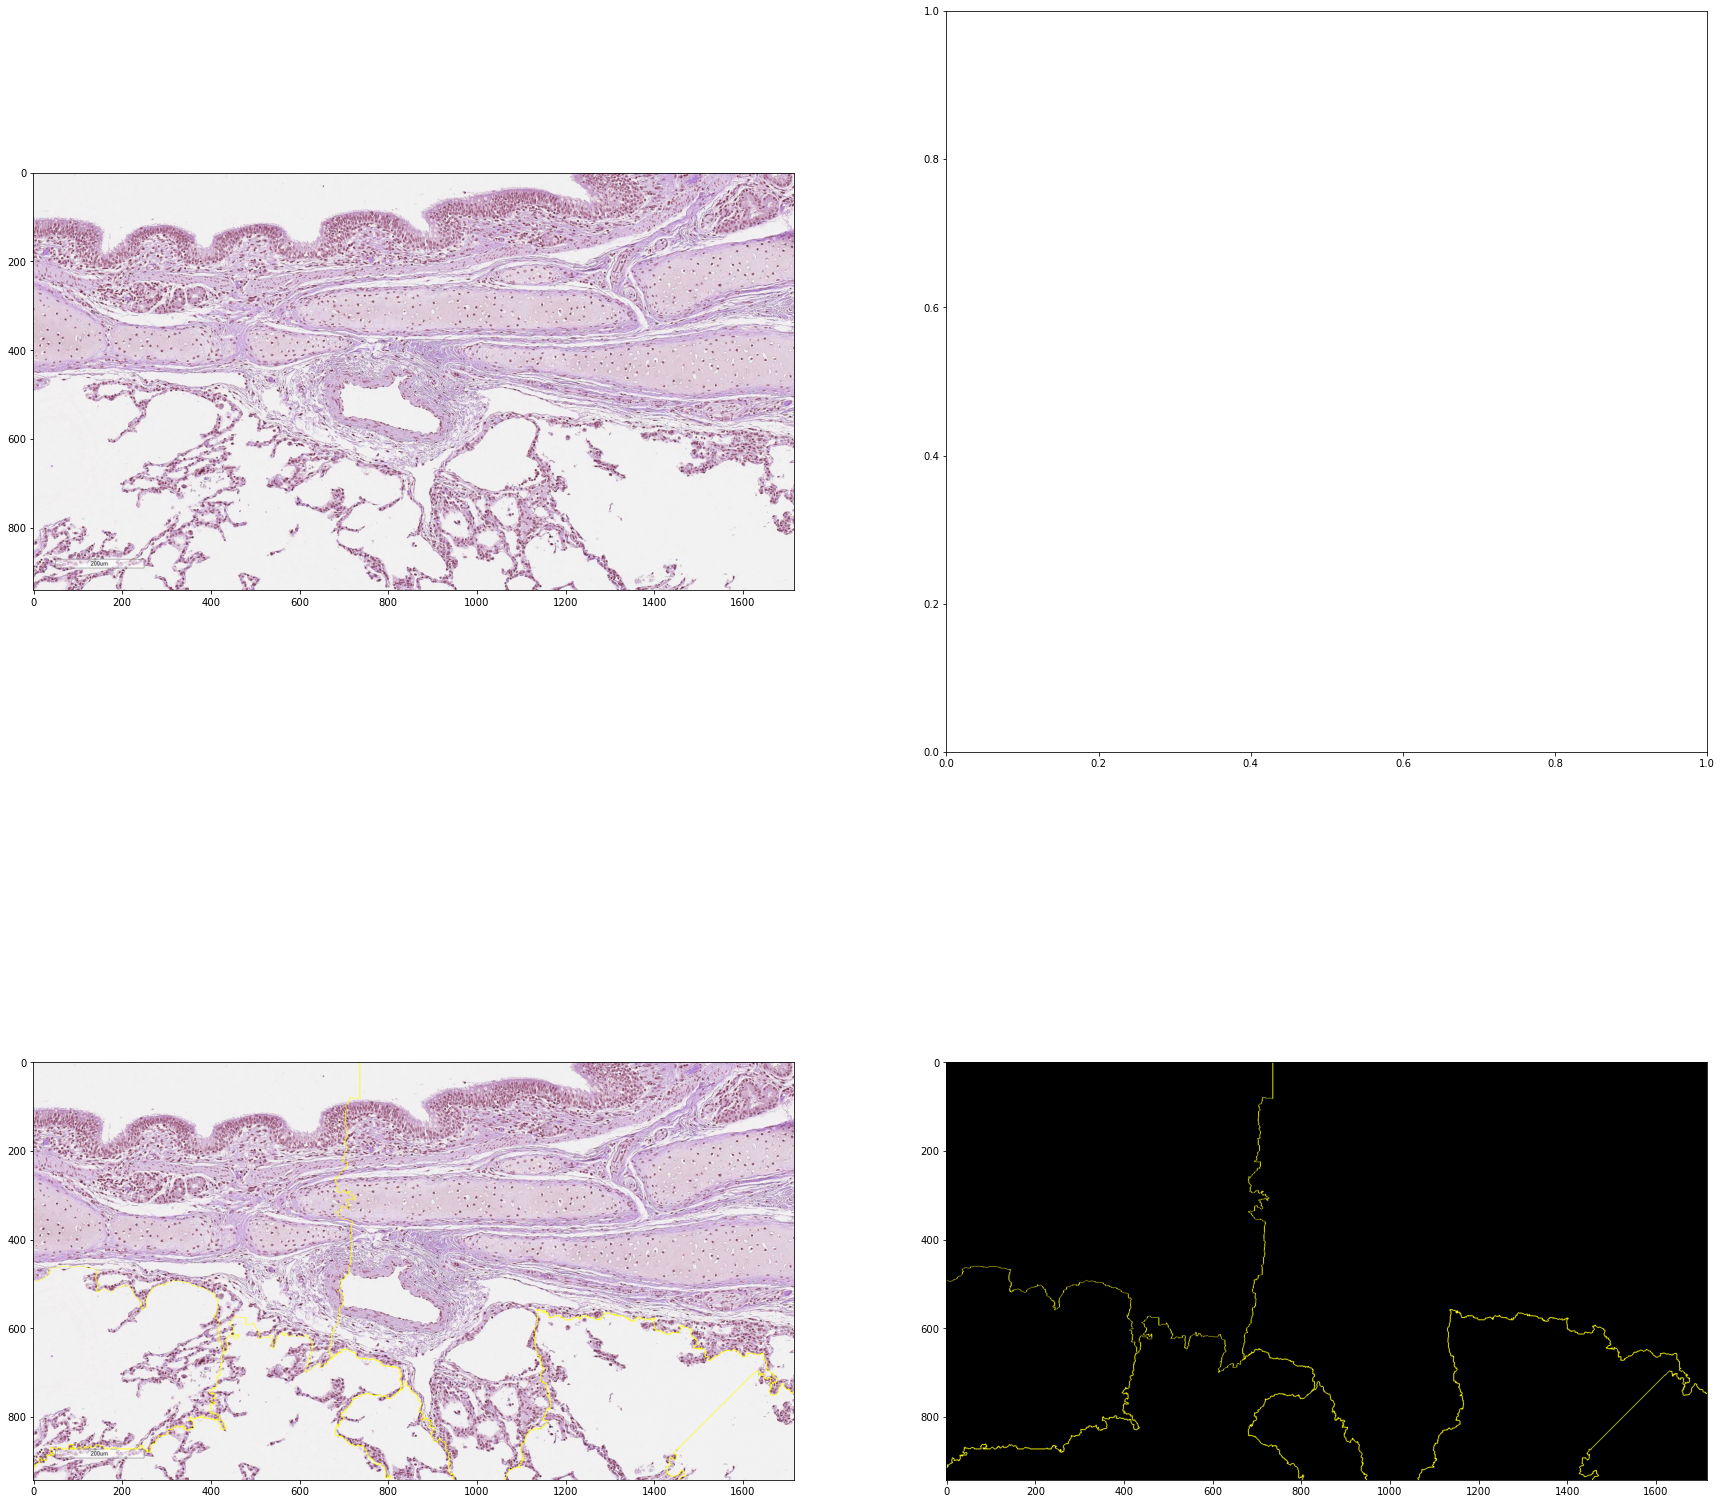

In [42]:
bilat_im = cv2.bilateralFilter(im, d=10, sigmaColor=80, sigmaSpace=80)
segments = slic(im, n_segments=50, compactness=0.1, start_label=0)
fig, axs = plt.subplots(2, 2, figsize=(30,30))
axs[0, 0].imshow(im)
axs[0, 1].imshow(bilat_im)
axs[1, 0].imshow(mark_boundaries(im, segments))
axs[1, 1].imshow(mark_boundaries(np.zeros_like(im), segments))

In [4]:
def im2graph(im, n_segments=10000, compactness=0.1):
    segments = slic(im, n_segments=n_segments, compactness=compactness, start_label=0)
    num_nodes = np.unique(segments).shape[0]
    graph = np.zeros((num_nodes, num_nodes))
    sp_means = {i:np.mean(im[np.where(segments==i)]) for i in np.unique(segments)}
    for x in range(im.shape[0]-1):
        for y in range(im.shape[1]-1):
            if segments[x, y] != segments[x+1, y]:
                edge_weight = (sp_means[segments[x, y]]-sp_means[segments[x+1, y]])**2
                graph[segments[x, y],segments[x+1, y]] = 1-edge_weight
                graph[segments[x+1, y],segments[x, y]] = 1-edge_weight
            if segments[x, y] != segments[x, y+1]:
                edge_weight = (sp_means[segments[x, y]]-sp_means[segments[x, y+1]])**2
                graph[segments[x, y],segments[x, y+1]] = 1-edge_weight
                graph[segments[x, y+1],segments[x, y]] = 1-edge_weight
    return graph

In [5]:
G = Graph.from_adj(im2graph(im))

In [6]:
G.adj[G.adj<0.8]=0

In [7]:
G.adj[G.adj>0].shape

(43616,)

In [16]:
groups = [set(list(np.where(i>0)[0])+[n]) for n,i in enumerate(G.adj)]

In [9]:
merged_groups = []
for i in tqdm(range(len(groups))):
    x = groups[i]
    for j in range(len(groups)):
        if x.intersection(groups[j]):
            x = x.union(groups[j])
    if x not in merged_groups:
        merged_groups.append(x)

100%|██████████| 7821/7821 [07:37<00:00, 17.09it/s] 


In [67]:
merged_groups = []
completed_nodes = set()
for i in tqdm(groups):
    if len(completed_nodes)==len(groups):
        break
    x = i.copy()
    for j in groups:
        if x.intersection(j):
                x = x.union(j)
                completed_nodes.update(j)
    if not x in merged_groups:
        print(x)
        merged_groups.append(x)

  0%|          | 2/7821 [00:00<23:53,  5.45it/s]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

  0%|          | 9/7821 [00:01<24:13,  5.37it/s]

{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

  0%|          | 12/7821 [00:02<23:38,  5.50it/s]

{6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

  0%|          | 14/7821 [00:02<23:34,  5.52it/s]

{8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232

  0%|          | 16/7821 [00:02<23:48,  5.46it/s]

{10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,

  0%|          | 18/7821 [00:03<23:59,  5.42it/s]

{12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 136, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 23

  0%|          | 21/7821 [00:03<23:33,  5.52it/s]

{15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249,

  0%|          | 26/7821 [00:05<28:24,  4.57it/s]

{16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 217, 218, 219, 222, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 

  0%|          | 29/7821 [00:05<24:52,  5.22it/s]

{16, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 139, 140, 141, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 212, 213, 214, 215, 216, 217, 218, 219, 222, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262,

  0%|          | 33/7821 [00:06<23:24,  5.54it/s]

{27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 134, 139, 140, 141, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 213, 214, 215, 216, 217, 218, 219, 222, 225, 226, 227, 228, 229, 230, 234, 235, 236, 237, 238, 239, 242, 243, 244, 247, 248, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 28

  0%|          | 39/7821 [00:07<22:41,  5.71it/s]

{32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 132, 133, 134, 139, 140, 141, 148, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 213, 214, 215, 217, 218, 219, 222, 226, 227, 228, 229, 230, 235, 236, 237, 238, 239, 242, 243, 244, 248, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 29

  1%|          | 43/7821 [00:08<22:33,  5.75it/s]

{32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 132, 133, 134, 139, 140, 141, 148, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 210, 213, 214, 215, 217, 218, 219, 222, 226, 227, 228, 229, 230, 235, 236, 237, 238, 239, 242, 243, 244, 248, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 2

  1%|          | 46/7821 [00:08<22:29,  5.76it/s]

{39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 117, 118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 133, 134, 140, 141, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 210, 213, 214, 215, 217, 218, 219, 222, 227, 228, 229, 230, 236, 237, 238, 239, 242, 243, 244, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 304, 305, 306, 308, 309, 310, 311, 312, 317, 318, 

  1%|          | 49/7821 [00:09<22:31,  5.75it/s]

{41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 117, 118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 133, 134, 140, 141, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 210, 213, 214, 215, 217, 218, 219, 222, 227, 228, 229, 230, 236, 237, 238, 239, 242, 243, 244, 249, 250, 251, 252, 253, 254, 258, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 304, 305, 306, 308, 309, 310, 311, 312, 317, 318, 320, 321

  1%|          | 54/7821 [00:09<22:08,  5.85it/s]

{48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 118, 121, 122, 123, 124, 126, 140, 141, 149, 150, 151, 157, 158, 159, 160, 161, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 217, 218, 219, 227, 228, 229, 230, 237, 238, 239, 243, 244, 250, 251, 252, 253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 308, 309, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 342, 343, 344, 345, 346, 349, 350, 351, 352, 355, 359, 360, 361, 362, 363, 364, 365, 366, 371, 372, 373, 374, 3

  1%|          | 58/7821 [00:10<21:52,  5.92it/s]

{48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 118, 121, 122, 123, 124, 126, 140, 141, 149, 150, 151, 157, 158, 159, 160, 161, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 217, 218, 219, 227, 228, 229, 230, 237, 238, 239, 243, 244, 250, 251, 252, 253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 308, 309, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 342, 343, 344, 345, 346, 349, 350, 351, 352, 355, 359, 360, 361, 362, 363, 364, 365, 366, 371, 372, 373, 374, 375, 

  1%|          | 61/7821 [00:11<21:51,  5.92it/s]

{51, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 118, 121, 123, 124, 126, 140, 141, 151, 157, 158, 159, 160, 161, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 218, 219, 229, 230, 239, 251, 252, 253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 

  1%|          | 63/7821 [00:11<21:47,  5.93it/s]

{57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 157, 158, 159, 160, 161, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 218, 219, 229, 239, 251, 252, 253, 254, 259, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 405, 406, 40

  1%|          | 65/7821 [00:11<21:49,  5.92it/s]

{59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 219, 239, 251, 252, 253, 254, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 405, 406, 407, 409, 410, 411, 412, 416, 

  1%|          | 69/7821 [00:12<21:37,  5.97it/s]

{63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 219, 239, 251, 252, 253, 254, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 405, 406, 407, 409, 410, 411, 412, 416, 420, 425, 426, 429, 432, 4

  1%|          | 71/7821 [00:12<21:38,  5.97it/s]

{65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 219, 239, 251, 252, 253, 254, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 405, 406, 407, 409, 410, 411, 412, 416, 420, 425, 426, 429, 432, 433, 434, 439, 440,

  1%|          | 73/7821 [00:13<21:41,  5.96it/s]

{68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 203, 206, 207, 208, 213, 214, 215, 219, 239, 251, 252, 253, 254, 260, 261, 262, 263, 264, 265, 266, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 305, 306, 310, 311, 312, 318, 320, 321, 322, 323, 326, 331, 337, 338, 343, 344, 345, 346, 349, 350, 351, 352, 355, 361, 362, 363, 364, 365, 366, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 405, 406, 407, 409, 410, 411, 412, 416, 420, 425, 426, 429, 432, 433, 434, 439, 440, 441, 442, 443, 4

  1%|          | 75/7821 [00:13<21:27,  6.02it/s]

{70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 263, 264, 265, 266, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 306, 318, 320, 321, 323, 326, 331, 337, 338, 345, 346, 351, 352, 355, 362, 363, 364, 365, 366, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 406, 407, 410, 411, 412, 416, 420, 426, 434, 439, 440, 441, 442, 443, 448, 457, 464, 465, 466, 467, 468, 469, 470, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 497, 498, 499, 500, 501, 506, 507, 508,

  1%|          | 77/7821 [00:13<21:05,  6.12it/s]

{72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 263, 264, 265, 266, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 306, 318, 320, 321, 323, 326, 331, 337, 338, 345, 346, 351, 352, 355, 362, 363, 364, 365, 366, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 398, 399, 400, 401, 406, 407, 410, 411, 412, 416, 420, 426, 434, 439, 440, 441, 442, 443, 448, 457, 464, 465, 466, 467, 468, 469, 470, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 497, 498, 499, 500, 501, 506, 507, 508, 516, 517, 518, 522, 52

  1%|          | 79/7821 [00:14<20:41,  6.24it/s]

{74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 411, 412, 416, 420, 426, 434, 440, 441, 442, 443, 448, 457, 465, 466, 467, 468, 469, 470, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 498, 499, 500, 501, 507, 508, 516, 517, 518, 525, 526, 527, 533, 534, 540, 541, 542, 547, 548, 553, 554, 555, 561, 562, 563, 564, 576, 577, 578, 579, 580, 581, 

  1%|          | 81/7821 [00:14<20:24,  6.32it/s]

{76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 457, 465, 466, 467, 468, 469, 470, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 498, 499, 500, 501, 507, 508, 516, 517, 518, 525, 526, 527, 534, 540, 541, 542, 547, 548, 554, 555, 562, 563, 564, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 598, 599, 600, 601, 608

  1%|          | 83/7821 [00:14<20:38,  6.25it/s]

{78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 652, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 687, 688, 6

  1%|          | 85/7821 [00:15<19:45,  6.53it/s]

{80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 706, 707,

  1%|          | 87/7821 [00:15<21:01,  6.13it/s]

{82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 386, 387, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 78

  1%|          | 89/7821 [00:15<19:42,  6.54it/s]

{84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 191, 192, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 388, 389, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 486, 487, 488, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 693, 694, 695, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 796, 797, 798, 799, 800, 801, 802, 803, 804, 808, 811, 

  1%|          | 91/7821 [00:15<18:56,  6.80it/s]

{86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 193, 194, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 390, 391, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 488, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 585, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 695, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 798, 799, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880

  1%|          | 93/7821 [00:16<18:31,  6.95it/s]

{88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 195, 196, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 293, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 799, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880, 881, 889, 890, 891, 906, 907, 908, 909, 910, 911, 912, 9

  1%|▏         | 98/7821 [00:16<18:07,  7.10it/s]

{90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 197, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 294, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 392, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 489, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 799, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880, 881, 889, 890, 891, 906, 907, 908, 909, 910, 911, 912, 913, 916, 923, 940, 944,

  1%|▏         | 104/7821 [00:17<17:58,  7.16it/s]

{95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 123, 124, 126, 140, 141, 151, 158, 159, 160, 161, 198, 199, 213, 214, 215, 219, 239, 252, 253, 254, 264, 265, 266, 295, 296, 297, 298, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 363, 364, 365, 366, 393, 394, 400, 401, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 490, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 586, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 696, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 799, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880, 881, 889, 890, 891, 906, 907, 908, 909, 910, 911, 912, 913, 916, 923, 940, 944, 945, 946, 953, 954, 955, 956, 957, 978, 984

  1%|▏         | 107/7821 [00:18<17:51,  7.20it/s]

{101, 102, 103, 104, 105, 106, 107, 108, 109, 118, 121, 124, 126, 140, 141, 161, 213, 215, 219, 239, 253, 254, 265, 266, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 364, 365, 366, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880, 881, 889, 890, 891, 907, 908, 909, 910, 911, 912, 913, 916, 923, 940, 944, 945, 946, 953, 954, 955, 956, 957, 978, 984, 985, 997, 998, 999, 1000, 1001, 1002, 1007, 1008, 1015, 1016, 1017, 1018, 1021, 1025, 1040, 1046, 1047, 1054, 1061, 1068, 1069, 1082, 1092,

  2%|▏         | 126/7821 [00:21<20:14,  6.33it/s]

{101, 102, 103, 105, 106, 107, 108, 109, 118, 121, 124, 126, 140, 141, 161, 213, 215, 219, 239, 253, 254, 265, 266, 299, 300, 318, 320, 321, 323, 326, 337, 338, 345, 346, 351, 352, 355, 364, 365, 366, 407, 412, 416, 420, 426, 434, 442, 443, 448, 465, 466, 467, 468, 469, 470, 491, 492, 493, 499, 500, 501, 507, 508, 516, 517, 518, 527, 541, 542, 547, 548, 555, 563, 564, 587, 588, 589, 590, 591, 592, 593, 599, 600, 601, 609, 610, 619, 624, 630, 653, 654, 655, 663, 664, 665, 666, 670, 671, 674, 675, 697, 698, 699, 700, 701, 706, 707, 708, 716, 721, 722, 733, 738, 746, 747, 755, 764, 765, 766, 767, 768, 781, 782, 783, 800, 801, 802, 803, 804, 808, 811, 814, 818, 823, 824, 828, 841, 848, 849, 850, 866, 867, 868, 869, 870, 871, 880, 881, 889, 890, 891, 907, 908, 909, 910, 911, 912, 913, 916, 923, 940, 944, 945, 946, 953, 954, 955, 956, 957, 978, 984, 985, 997, 998, 999, 1000, 1001, 1002, 1007, 1008, 1015, 1016, 1017, 1018, 1021, 1025, 1040, 1046, 1047, 1054, 1061, 1068, 1069, 1082, 1092, 1093

  3%|▎         | 268/7821 [00:44<21:04,  5.97it/s]


KeyboardInterrupt: 

In [62]:
merged_groups

[]